In [29]:
import pandas as pd 
import plotly.express as px
import pandas as pd 
from darts import TimeSeries
import logging
from darts.metrics import mae, mse
from datetime import datetime
import pytz
from darts.models import Prophet,LightGBMModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import pandas as pd
from darts.timeseries import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics.metrics import mse
from darts.dataprocessing.transformers import Scaler
import os

import matplotlib.pyplot as plt 
import scienceplots

plt.style.use('science')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
data = pd.read_csv('/home/alqua/Data/inflow_and_weather_data.csv')

In [31]:
start_date="2023-02-01" 
end_date="2023-03-01"

data = data[(data['time'] >= start_date) & (data['time'] <= end_date)]


In [32]:
data

,time,inflow,precip_past1min,wind_speed,humidity
0,2023-02-01 00:00:00+00:00,343.628476,0.00,740.018333,0.0
1,2023-02-01 01:00:00+00:00,327.030658,0.09,758.983333,0.0
2,2023-02-01 02:00:00+00:00,327.559384,0.00,735.006667,0.0
3,2023-02-01 03:00:00+00:00,317.812062,0.00,755.013333,0.0
4,2023-02-01 04:00:00+00:00,320.180150,0.00,651.018333,0.0
...,...,...,...,...,...
667,2023-02-28 19:00:00+00:00,373.556656,0.00,244.006667,0.0
668,2023-02-28 20:00:00+00:00,354.218828,0.00,197.013333,0.0
669,2023-02-28 21:00:00+00:00,349.244418,0.00,230.003333,0.0
670,2023-02-28 22:00:00+00:00,324.715720,0.00,216.975000,0.0


In [33]:
data["time"] = pd.to_datetime(data["time"])

In [34]:
data = data.set_index("time")
data["inflow"] = data["inflow"].ewm(alpha=0.3).mean()

In [35]:
data.head(5)

,inflow,precip_past1min,wind_speed,humidity
time,,,,
2023-02-01 00:00:00+00:00,343.628476,0.00,740.018333,0.0
2023-02-01 01:00:00+00:00,333.865054,0.09,758.983333,0.0
2023-02-01 02:00:00+00:00,330.985753,0.00,735.006667,0.0
2023-02-01 03:00:00+00:00,325.784927,0.00,755.013333,0.0
2023-02-01 04:00:00+00:00,323.763804,0.00,651.018333,0.0


In [36]:
def to_darts_timeseries(data: pd.DataFrame, training_cutoff,  filling_nan = True, train_test_split = True, scale=False):
    series = TimeSeries.from_dataframe(data, freq="1H")
    ts_series = fill_missing_values(series)
    
    if filling_nan and train_test_split and scale:
        print("scaling")
        transformer = Scaler()
        ts_series = transformer.fit_transform(ts_series)
        train_df, test_df = ts_series.split_after(training_cutoff)
        return transformer, ts_series, train_df, test_df
    
    elif filling_nan and train_test_split and not scale:
        train_df, test_df = ts_series.split_after(training_cutoff)
        return ts_series, train_df, test_df
    
    elif filling_nan and not train_test_split and not scale:
        ts_series = fill_missing_values(series)
        return ts_series

In [37]:
training_cutoff = pd.Timestamp("20230224")
ts_series, train_df, test_df = to_darts_timeseries(data, training_cutoff,  train_test_split=True, scale=False)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [38]:
def generate_covariates(ts_series):
    year_covariates   = datetime_attribute_timeseries(ts_series, attribute="year", one_hot=False)
    month_covariates  = datetime_attribute_timeseries(ts_series, attribute="month", one_hot=False)
    day_covariates    = datetime_attribute_timeseries(ts_series, attribute="day", one_hot=False)
    hour_covariates   = datetime_attribute_timeseries(ts_series, attribute="hour", one_hot=False)
    precip_covariates = ts_series["precip_past1min"]
    wind_covariates   = ts_series["wind_speed"]
    humidity_covariates = ts_series["humidity"]

    future_cov =  precip_covariates.stack(wind_covariates).stack(year_covariates).stack(month_covariates).stack(day_covariates).stack(hour_covariates)

    return future_cov


In [39]:
prophet_model = Prophet()

In [40]:
#generate chunks
chunks = [test_df.pd_dataframe()[i:i + 24] for i in range(0, test_df.pd_dataframe().shape[0], 24)]

In [41]:
len(chunks)

5

In [42]:
fh = 24
results_df = pd.DataFrame()
predictions_series_lower_q = pd.Series()
predictions_series_median_q = pd.Series()
predictions_series_upper_q = pd.Series()

for chunk in chunks[:3]:
    #generate past covariates on the past dataset 
    past_cov_dataframe = generate_covariates(train_df)
    prophet_model.fit(train_df["inflow"], future_covariates=past_cov_dataframe) 

    #generate timeseries object from forecasts dataframe
    future_dataframe = TimeSeries.from_dataframe(chunk, freq="1H")
    results_df = pd.concat([results_df, chunk])
    #extract the future inflow (not included in the model)
    unobserved_inflow = future_dataframe["inflow"]
    #generate future covariates on new observation
    future_cov_dataframe = generate_covariates(future_dataframe)
    future_cov_dataframe = past_cov_dataframe.concatenate(future_cov_dataframe) 
    #predict the next 24 hours
    prophet_predictions = prophet_model.predict(fh, future_covariates=future_cov_dataframe,  num_samples=200)

    predictions_series_lower_q = pd.concat([predictions_series_lower_q, prophet_predictions.quantile_df(0.1)["inflow_0.1"]], axis=0)
    predictions_series_median_q = pd.concat([predictions_series_median_q, prophet_predictions.quantile_df(0.5)["inflow_0.5"]], axis=0)
    predictions_series_upper_q = pd.concat([predictions_series_upper_q, prophet_predictions.quantile_df(0.9)["inflow_0.9"]], axis=0)

    #evaluate the prediction with the mae 
    #print(mae(prophet_predictions.quantile_timeseries(0.05), unobserved_inflow))
    #concatenate the old observation with the new data to enable new predictions
    train_df = train_df.concatenate(future_dataframe)

23:01:38 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] done processing
23:01:39 - cmdstanpy - INFO - Chain [1] start processing


23:01:39 - cmdstanpy - INFO - Chain [1] done processing
23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
results_df["inflow_0.1"] = predictions_series_lower_q
results_df["inflow_0.5"] = predictions_series_median_q
results_df["inflow_0.9"] = predictions_series_upper_q

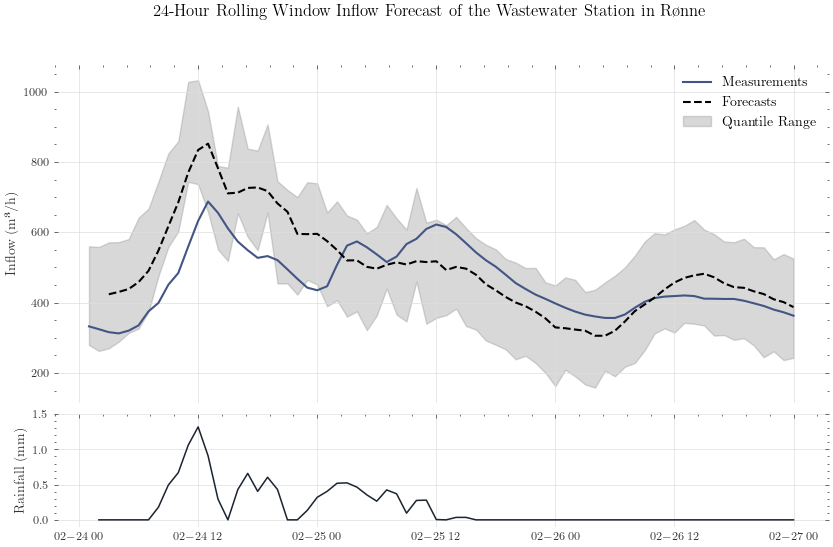

In [44]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

# Create figure and GridSpec layout
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

# Main Time Series Plot
ax1 = fig.add_subplot(gs[0])
ax1.plot(results_df["inflow"].index, results_df["inflow"], color="#435585", linewidth=1.5, label="Measurements")
ax1.plot(results_df["inflow"].index, results_df["inflow_0.5"].rolling(3).mean(), linestyle="dashed", color="black", linewidth=1.5, label="Forecasts")
ax1.fill_between(results_df["inflow"].index, results_df["inflow_0.1"], results_df["inflow_0.9"], color='gray', alpha=0.3, label='Quantile Range')
ax1.set_ylabel('Inflow (m³/h)')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax1.legend()

# Regressor Data Plot
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(results_df["precip_past1min"].index, results_df["precip_past1min"].rolling(2).mean(), linewidth=1.1, color = "#1B2430")
ax2.set_ylim((-0.1,1.5))
ax2.set_ylabel('Rainfall (mm)')

plt.setp(ax1.get_xticklabels(), visible=False)

# Adding a final title to the figure
fig.suptitle('24-Hour Rolling Window Inflow Forecast of the Wastewater Station in Rønne', fontsize=12)

#save image
#plt.savefig("prophet_forecast_results.pdf", format='pdf', dpi=300)
plt.show()